In [0]:
import pandas as pd
import numpy as np
from numpy import *
from numpy import linalg as la
from sklearn.metrics import mean_squared_error
import tqdm

In [0]:
# decrease dimension of sigma to smaller one which keep 90% original information
# and return new dimension.
def findDimension(sigma):
    count = 0
    sig2 = sigma**2
    sumsig = sum(sig2)
    for i in range(len(sig2)):
        count += sig2[i]
        if count >= 0.9*sumsig:
            return i+1

# Using pearson corelation to calculate similarity of two vectors.
def pearsSim(A,B):
    if len(A)<3:return 1.0
    return 0.5+0.5*corrcoef(A,B,rowvar=0)[0][1]

# The sum of multiplication of every similaritis and corresponding rating
# is prediction rating.
def similarity(dataMat,pivotTable,user,item):
    global xformedUsers
    n = shape(dataMat)[0]
    simTotal = 0.0
    ratSimTotal = 0.0
    for j in range(n):
        userRating = pivotTable.loc[j+1][item]
        if userRating==0 or j==user-1:
            continue
        similarity = pearsSim(xformedUsers[user-1,:].T,xformedUsers[j,:].T)
        simTotal += similarity
        ratSimTotal += similarity*userRating
    if simTotal ==0:
        return 0
    else:
        return ratSimTotal/simTotal

# return prediction rating of every pair of user ID and movie ID in test files.
def recommandsingle(pivotTable,user,item):
    dataMat = mat(pivotTable)
    unratedItems = []
    for index,value in pivotTable.loc[user].iteritems():
        if value == 0:
            unratedItems.append(index)
    if len(unratedItems)==0: return 'you rated every movies.'
#     itemScores = []
    if item not in unratedItems:
        return None
    else:
        return similarity(dataMat,pivotTable,user,item)

# calculate 5 MSE of 5 pairs of base and test files
# for each pair of base and test file, use SVD function in numpy linalg package
# to get U,sigma,VT. We focus on user features to predict ratings, so we get 
# transformed data matrix by formula dataMat*VT(n,k)*sigma[k] (k is the lower 
# dimention after sliced in findDimension function).
all_test_MSE = []
for i in range(1,6):
    print("Fold : "+str(i))
    r_cols = ['userId', 'movieId', 'rating',"timeStamp"]
    ratings = pd.read_csv('drive/My Drive/comp9417-project/SVD based on user features/ml-100k/u'+str(i)+'.base', sep='\t', names=r_cols,usecols = range(3),encoding='latin-1')

    trainRatingsPivotDF = pd.pivot_table(ratings[['userId','movieId','rating']],columns=['movieId'],index=['userId'],values='rating',fill_value=0)
    
    U,Sigma,VT = la.svd(mat(trainRatingsPivotDF))
    lowDimension = findDimension(Sigma)
    Sig4 = mat(eye(lowDimension)*Sigma[:lowDimension])
    xformedUsers = mat(trainRatingsPivotDF)*VT[:,:lowDimension]*Sig4.I

    r_cols = ['userId', 'movieId', 'rating',"timeStamp"]
    test = pd.read_csv('drive/My Drive/comp9417-project/SVD based on user features/ml-100k/u'+str(i)+'.test', sep='\t', names=r_cols,usecols = range(3),encoding='latin-1')
    
    predict_test = []
    for j in tqdm.trange(len(test)):
        prediction = recommandsingle(trainRatingsPivotDF,test.loc[j]["userId"],test.loc[j]["movieId"])
        predict_test.append(prediction) if prediction != None else predict_test.append(test.loc[j]["rating"])
    eachMSE = mean_squared_error(list(test["rating"]), predict_test)
    print("u"+str(i)+"_test_MSE:",eachMSE)
    all_test_MSE.append(eachMSE)
print(all_test_MSE)

Fold : 1


100%|██████████| 20000/20000 [35:29<00:00, 10.61it/s] 


u1_test_MSE: 1.0598082391086379
Fold : 2


100%|██████████| 20000/20000 [33:55<00:00,  9.83it/s]


u2_test_MSE: 1.052182458561083
Fold : 3


100%|██████████| 20000/20000 [34:05<00:00,  9.83it/s]


u3_test_MSE: 1.0322690464872062
Fold : 4


100%|██████████| 20000/20000 [34:52<00:00,  9.56it/s] 


u4_test_MSE: 1.0272494024410772
Fold : 5


100%|██████████| 20000/20000 [35:23<00:00,  9.42it/s] 

u5_test_MSE: 1.03890758873154
[1.0598082391086379, 1.052182458561083, 1.0322690464872062, 1.0272494024410772, 1.03890758873154]


In [0]:
# calculate mean MSE of all test files.
mean_MSE = np.mean(np.array(all_test_MSE))
print(mean_MSE)

1.0420833470659088


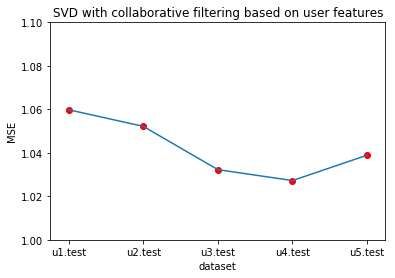

In [0]:
# Draw a MSE graph using all MSE result.
from matplotlib import pyplot as plt
file_test=["u1.test","u2.test","u3.test","u4.test","u5.test"]
plt.plot(file_test,all_test_MSE)
plt.scatter(file_test,all_test_MSE,color='red')
plt.xlabel("dataset")
plt.ylabel("MSE")
plt.ylim(1,1.1)
plt.title('SVD with collaborative filtering based on user features')
# plt.savefig('svdCF_mse-fig.jpg')
plt.show()